In [8]:
import sys

if "./" not in sys.path:
    sys.path.append("./")
from utils.share import *
import utils.config as config

import einops
import gradio as gr
import numpy as np
import cv2
import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3


from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler

from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from annotator.uniformer import UniformerDetector


apply_canny = CannyDetector()
apply_seg = UniformerDetector()

model = create_model("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/configs/vimeo/uni_v15.yaml").cpu()
model.load_state_dict(load_state_dict("/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/checkpoints/vimeo/uni_v15.ckpt", location="cuda"))
model = model.cuda()
ddim_sampler = DDIMSampler(model)


Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/annotator/ckpts/upernet_global_small.pth
UniControlNet: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Q

In [9]:
def process(
    canny_image,
    seg_image,
    prompt,
    a_prompt,
    n_prompt,
    num_samples,
    image_resolution,
    ddim_steps,
    strength,
    scale,
    seed,
    eta,
    global_strength,
    low_threshold=100, high_threshold=200, 
):

    seed_everything(seed)

    with torch.no_grad():
        # original_image = resize_image(HWC3(original_image), image_resolution)

        # H, W, C = original_image.shape
        W,H = image_resolution,image_resolution

        canny_image = cv2.resize(canny_image, (W, H))
        canny_detected_map = HWC3(apply_canny(HWC3(canny_image), low_threshold, high_threshold))

        seg_image = cv2.resize(seg_image, (W, H))
        seg_detected_map, _ = apply_seg(HWC3(seg_image))
        seg_detected_map = HWC3(seg_detected_map)

        content_emb = np.zeros((768))

        detected_maps = np.concatenate([canny_detected_map,seg_detected_map], axis=2)

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, "b h w c -> b c h w").clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack(
            [global_control for _ in range(num_samples)], dim=0
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {
            "local_control": [local_control],
            "c_crossattn": [
                model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
            ],
            "global_control": [global_control],
        }
        un_cond = {
            "local_control": [uc_local_control],
            "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
            "global_control": [uc_global_control],
        }
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=True,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
            global_strength=global_strength,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )
        results = [x_samples[i] for i in range(num_samples)]

    return (results, [canny_detected_map,seg_detected_map])

In [10]:
from PIL import Image
import numpy as np

a_prompt = "best quality, extremely detailed"
n_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
num_samples = 1
image_resolution = 512
ddim_steps = 50
strength = 1
scale = 7.5
seed = 42
eta = 0.0
global_strength = 1

def get_recons_img(prompt, original_image, local_image):
    pred = process(local_image,local_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, strength, scale, seed, eta, global_strength)
    recons_img = pred[0][0]

    # Ensure the images are of the same size
    if original_image.shape != recons_img.shape:
        recons_img = cv2.resize(recons_img, (original_image.shape[1], original_image.shape[0]))

    # Calculate residue
    residue = original_image - recons_img

    return recons_img, residue

Global seed set to 42


['data/00096_0576/im1.png', 'data/00096_0576/im2.png', 'data/00096_0576/im3.png', 'data/00096_0576/im4.png', 'data/00096_0576/im5.png', 'data/00096_0576/im6.png', 'data/00096_0576/im7.png']


/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.05it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im1_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.11it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im2_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.10it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im3_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.06it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im4_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.06it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im5_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.05it/s]
Global seed set to 42


Saved residue image: data/00096_0576/im6_residue.png
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.5215

DDIM Sampler: 100%|███████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.02it/s]


Saved residue image: data/00096_0576/im7_residue.png


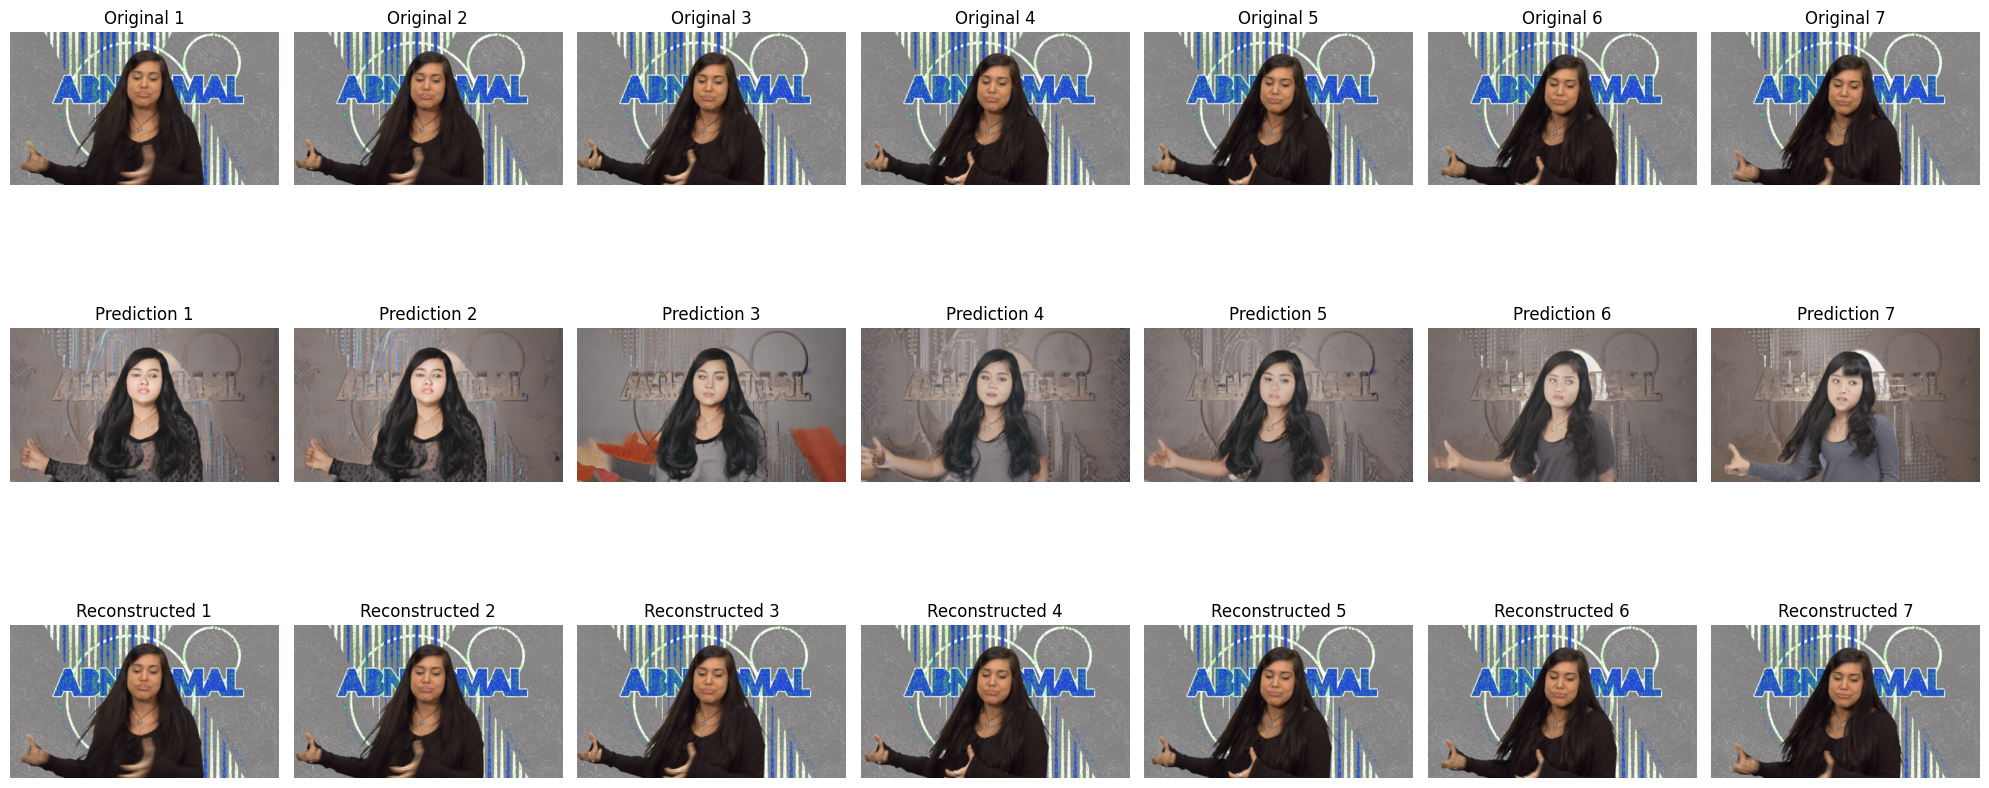

In [11]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Pick a random video and sequence
    image_paths = sorted(glob.glob('data/00096_0576/*.png'))
    print(image_paths)
    
    prompt = 'a girl with black hair and black shirt standing infront grey and blue background '

    original_images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in image_paths]

    reconstructed_images = []
    residues = []
    predictions = []

    for i, original_image in enumerate(original_images):
        if i == 0:
            pred_img, residue = get_recons_img(prompt, original_image, original_image)
        else:
            pred_img, residue = get_recons_img(prompt, original_image, reconstructed_images[-1])
        
        predictions.append(pred_img)
        residues.append(residue)
        reconstructed_images.append(pred_img + residue)

        # Save residue image
        residue_image_path = image_paths[i].replace(".png", "_residue.png")
        cv2.imwrite(residue_image_path, cv2.cvtColor(residue, cv2.COLOR_RGB2BGR))
        print(f"Saved residue image: {residue_image_path}")

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(3, len(original_images), figsize=(20, 10))
    for i in range(len(original_images)):
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis('off')
        axes[1, i].imshow(predictions[i])
        axes[1, i].set_title(f"Prediction {i + 1}")
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed_images[i])
        axes[2, i].set_title(f"Reconstructed {i + 1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
